In [1]:
import seaborn as sns
import numpy as np 
import pandas as pd 
import cv2
import matplotlib.pyplot as plt 
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
import keras
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Conv2D
from tensorflow.keras.optimizers import Adam 
from keras_tuner import RandomSearch
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.utils import shuffle
from tqdm import tqdm
from tensorflow.keras.applications import EfficientNetB0, InceptionResNetV2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint

import warnings
warnings.filterwarnings("ignore")

2023-09-11 11:06:56.895758: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-11 11:06:56.985063: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-11 11:06:56.987149: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-11 11:06:57.963541: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Load and Prepare Data

In [2]:
labels = ['glioma_tumor','no_tumor','meningioma_tumor','pituitary_tumor']


X_train = []
y_train = []

X_test = []
y_test = []

image_size = 75
for i in labels:
    folderPath = os.path.join('/mnt/c/Python/IDSS/BTC_inputs','Training',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size, image_size))
        X_train.append(img)
        y_train.append(i)
        
for i in labels:
    folderPath = os.path.join('/mnt/c/Python/IDSS/BTC_inputs','Testing',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size,image_size))
        X_test.append(img)
        y_test.append(i)
        
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test= np.array(X_test)
y_test = np.array(y_test)

100%|███████████████████████████████████████████████████████████████████████████████████| 74/74 [00:01<00:00, 39.01it/s]


## Augmenting the data

In [3]:
img_datagen = ImageDataGenerator(
    rotation_range=180,
    width_shift_range=0.4,
    height_shift_range=0.4,
    zoom_range=0.4,
    horizontal_flip=True)

img_datagen.fit(X_train)
img_datagen.fit(X_test)

## Exploratory Data Analysis

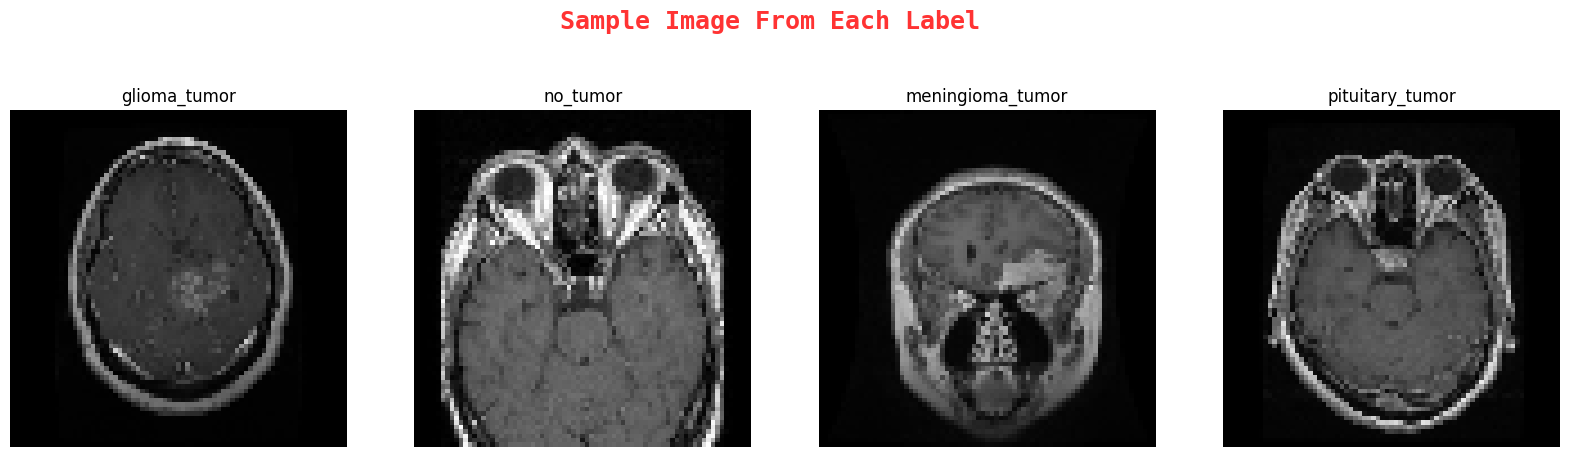

In [4]:
k=0
fig, ax = plt.subplots(1,4,figsize=(20,20))
fig.text(s='Sample Image From Each Label',size=18,fontweight='bold',
             fontname='monospace',color='r',y=0.62,x=0.4,alpha=0.8)
for i in labels:
    j=0
    while True :
        if y_train[j]==i:
            ax[k].imshow(X_train[j])
            ax[k].set_title(y_train[j])
            ax[k].axis('off')
            k+=1
            break
        j+=1

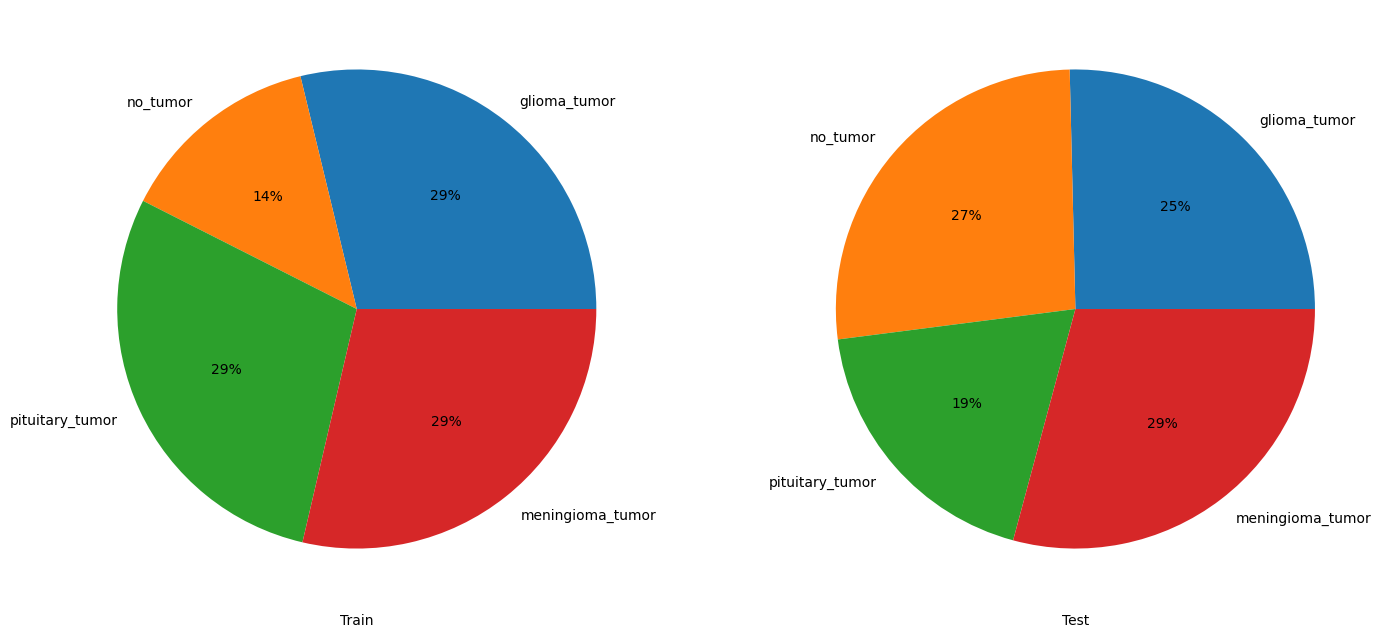

In [5]:
plt.figure(figsize = (17,8));
lis = ['Train', 'Test']
for i,j in enumerate([y_train, y_test]):
    plt.subplot(1,2, i+1);
    datax = []
    labelx = []
    for ix in set(j):
        datax.append(np.count_nonzero(j == ix))
        labelx.append(ix)
    plt.pie(datax, labels=labelx, autopct='%.0f%%')
    plt.xlabel(lis[i])

## Modelling

In [6]:
X_train, y_train = shuffle(X_train,y_train, random_state=101)
X_train,X_val,y_train,y_val = train_test_split(X_train,y_train, test_size=0.1,random_state=101)
print("Shape of train: ",(X_train).shape," and shape of val: ", (X_val).shape," and shape of test: ", (X_test).shape)

Shape of train:  (2583, 75, 75, 3)  and shape of val:  (287, 75, 75, 3)  and shape of test:  (394, 75, 75, 3)


In [7]:
y_train_new = []
for i in y_train:
    y_train_new.append(labels.index(i))
y_train = y_train_new
y_train = tf.keras.utils.to_categorical(y_train)


y_val_new = []
for i in y_val:
    y_val_new.append(labels.index(i))
y_val = y_val_new
y_val = tf.keras.utils.to_categorical(y_val)

y_test_new = []
for i in y_test:
    y_test_new.append(labels.index(i))
y_test = y_test_new
y_test = tf.keras.utils.to_categorical(y_test)

In [8]:
effnet = EfficientNetB0(weights='imagenet',include_top=False,input_shape=(image_size,image_size,3))
model = effnet.output
model = tf.keras.layers.GlobalAveragePooling2D()(model)
model = tf.keras.layers.Dropout(rate=0.5)(model)
model = tf.keras.layers.Dense(4,activation='softmax')(model)
model = tf.keras.models.Model(inputs=effnet.input, outputs = model)

2023-09-11 11:07:45.598276: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-09-11 11:07:45.599061: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [9]:
model.compile(loss='categorical_crossentropy',optimizer = 'Adam', metrics= ['accuracy'])
tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint("effnetv4.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 2, min_delta = 0.001,
                              mode='auto',verbose=1)

In [10]:
history = model.fit(X_train,y_train,validation_split=0.1, epochs =12, verbose=1, batch_size=32,
                   callbacks=[tensorboard,checkpoint,reduce_lr])

Epoch 1/12
73/73 [==============================] - ETA: 0s - loss: 0.6113 - accuracy: 0.7668
Epoch 1: val_accuracy improved from -inf to 0.71042, saving model to effnetv4.h5
73/73 [==============================] - 93s 987ms/step - loss: 0.6113 - accuracy: 0.7668 - val_loss: 0.7346 - val_accuracy: 0.7104 - lr: 0.0010
Epoch 2/12
73/73 [==============================] - ETA: 0s - loss: 0.3041 - accuracy: 0.9049
Epoch 2: val_accuracy improved from 0.71042 to 0.89961, saving model to effnetv4.h5
73/73 [==============================] - 66s 900ms/step - loss: 0.3041 - accuracy: 0.9049 - val_loss: 0.2682 - val_accuracy: 0.8996 - lr: 0.0010
Epoch 3/12
73/73 [==============================] - ETA: 0s - loss: 0.1683 - accuracy: 0.9363
Epoch 3: val_accuracy did not improve from 0.89961
73/73 [==============================] - 60s 829ms/step - loss: 0.1683 - accuracy: 0.9363 - val_loss: 0.4572 - val_accuracy: 0.8108 - lr: 0.0010
Epoch 4/12
73/73 [==============================] - ETA: 0s - loss:

# Evaluate Validation Accuracy/Loss 

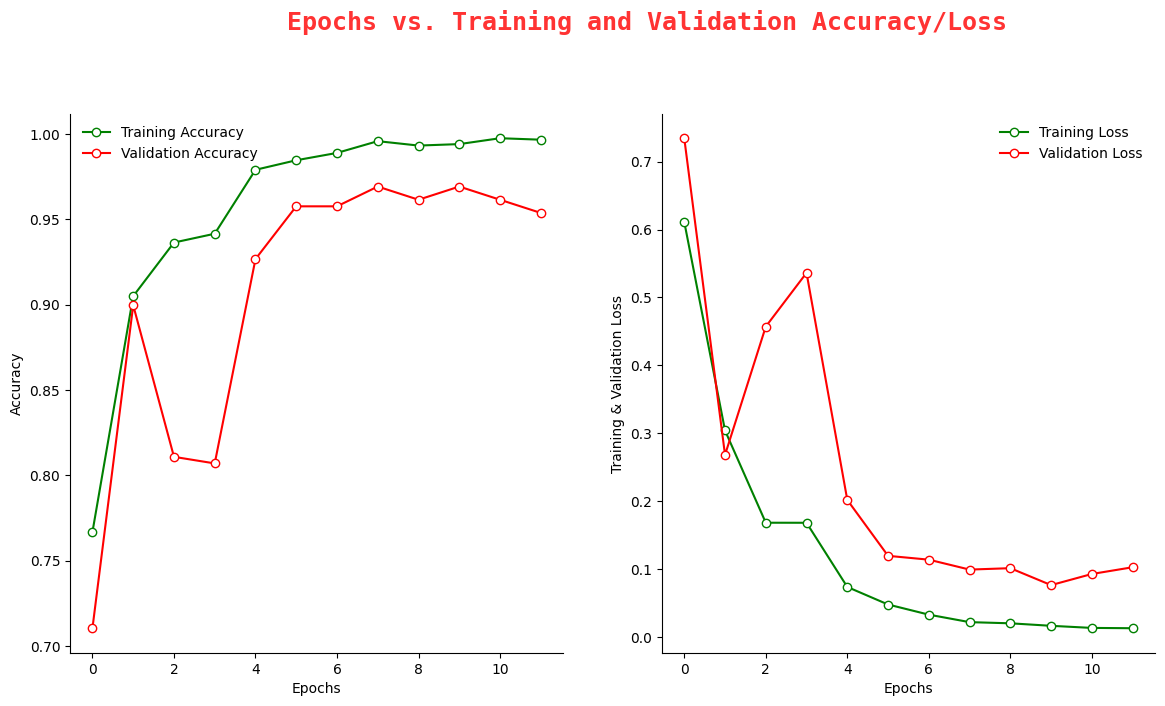

In [11]:
#filterwarnings('ignore')

epochs = [i for i in range(12)]
fig, ax = plt.subplots(1,2,figsize=(14,7))
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

fig.text(s='Epochs vs. Training and Validation Accuracy/Loss',size=18,fontweight='bold',
             fontname='monospace',color='r',y=1,x=0.28,alpha=0.8)

sns.despine()
ax[0].plot(epochs, train_acc, marker='o',markerfacecolor='w',color='g',
           label = 'Training Accuracy')
ax[0].plot(epochs, val_acc, marker='o',markerfacecolor='w',color='r',
           label = 'Validation Accuracy')
ax[0].legend(frameon=False)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')

sns.despine()
ax[1].plot(epochs, train_loss, marker='o',markerfacecolor='w',color='g',
           label ='Training Loss')
ax[1].plot(epochs, val_loss, marker='o',markerfacecolor='w',color='r',
           label = 'Validation Loss')
ax[1].legend(frameon=False)
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Training & Validation Loss')
fig.show()

## Check model on validation dataset

In [12]:
#load model
model = tf.keras.models.load_model('effnetv4.h5')

In [13]:
pred = model.predict(X_val)
pred_val = np.argmax(pred,axis=1)
y_val_new = np.argmax(y_val,axis=1)

9/9 [==============================] - 4s 274ms/step


In [14]:
print(classification_report(y_val_new,pred_val,target_names=labels))

                  precision    recall  f1-score   support

    glioma_tumor       0.96      0.95      0.95        92
        no_tumor       0.93      1.00      0.96        37
meningioma_tumor       0.92      0.92      0.92        78
 pituitary_tumor       0.99      0.96      0.97        80

        accuracy                           0.95       287
       macro avg       0.95      0.96      0.95       287
    weighted avg       0.95      0.95      0.95       287



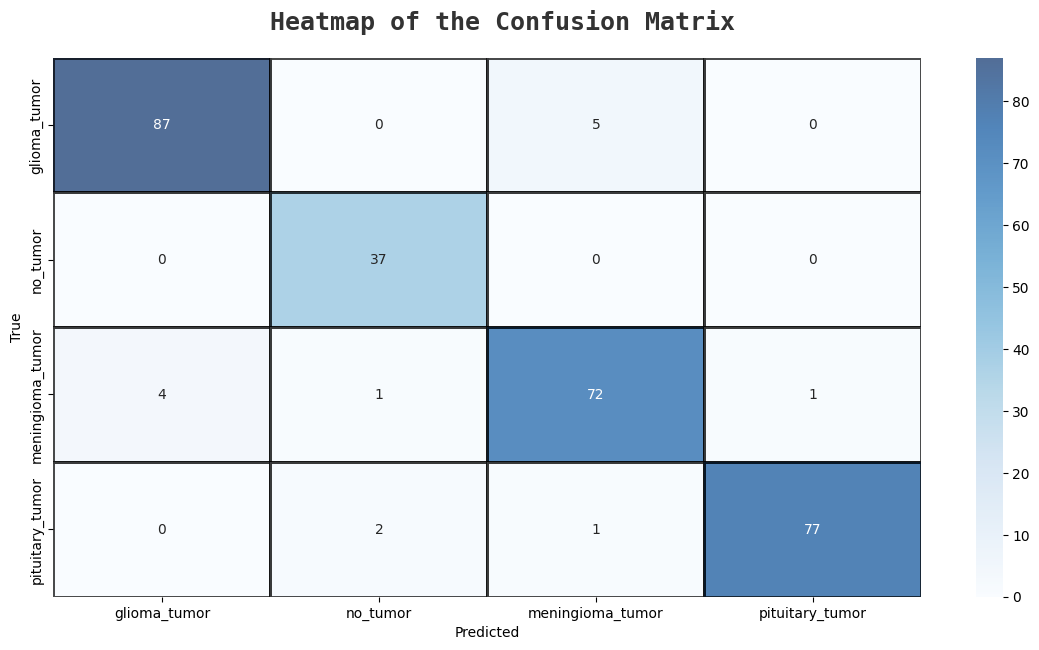

In [15]:
fig,ax=plt.subplots(1,1,figsize=(14,7))
sns.heatmap(confusion_matrix(y_val_new,pred_val),
            ax=ax,xticklabels=labels,
            yticklabels=labels,annot=True,
            cmap='Blues',alpha=0.7,linewidths=2,linecolor='k',fmt='g')
fig.text(s='Heatmap of the Confusion Matrix',size=18,fontweight='bold',
         fontname='monospace',color='k',y=0.92,x=0.28,alpha=0.8)
plt.ylabel('True')
plt.xlabel('Predicted')
plt.show()

## Check model on test dataset

In [16]:
pred = model.predict(X_test)
pred_test = np.argmax(pred,axis=1)
y_test_new = np.argmax(y_test,axis=1)
print(classification_report(y_test_new,pred_test,target_names=labels))

13/13 [==============================] - 2s 184ms/step
                  precision    recall  f1-score   support

    glioma_tumor       1.00      0.22      0.36       100
        no_tumor       0.74      1.00      0.85       105
meningioma_tumor       0.65      0.98      0.78       115
 pituitary_tumor       0.95      0.74      0.83        74

        accuracy                           0.75       394
       macro avg       0.84      0.74      0.71       394
    weighted avg       0.82      0.75      0.70       394



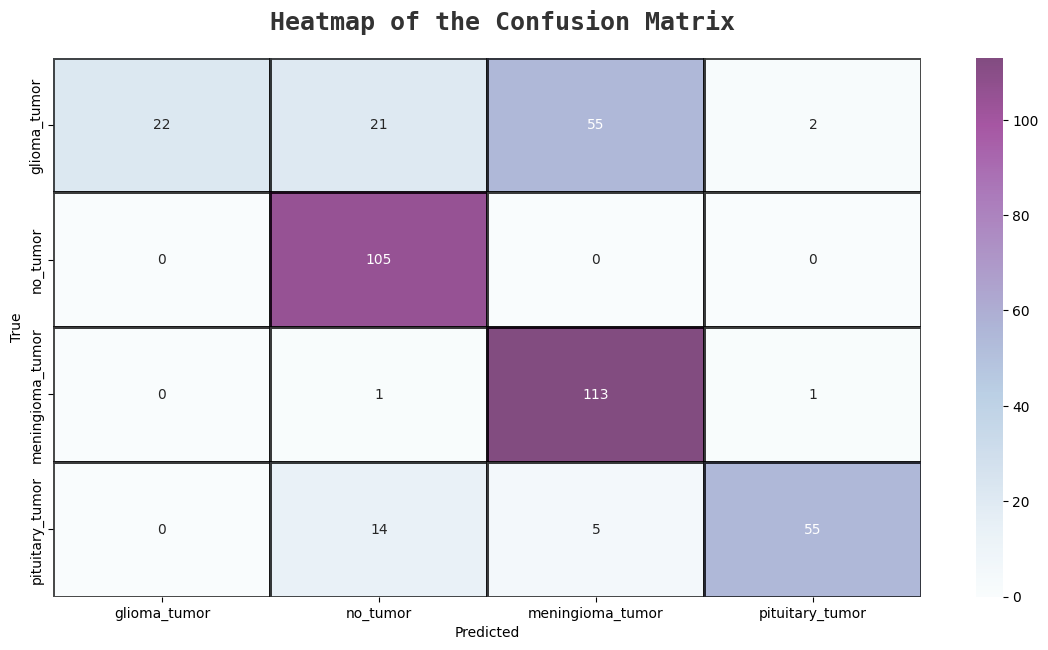

In [17]:
fig,ax=plt.subplots(1,1,figsize=(14,7))
sns.heatmap(confusion_matrix(y_test_new,pred_test),
            ax=ax,xticklabels=labels,
            yticklabels=labels,annot=True,
            cmap='BuPu',alpha=0.7,linewidths=2,linecolor='k',fmt='g')
fig.text(s='Heatmap of the Confusion Matrix',size=18,fontweight='bold',
         fontname='monospace',color='k',y=0.92,x=0.28,alpha=0.8)
plt.ylabel('True')
plt.xlabel('Predicted')
plt.show()